# Optimizer #1: Gradient Descent

## Intuition

Gradient descent is one of the most basic and fundamental optimization algorithms to mimimize loss functions in machine learning.

It is built upon the idea of a **gradient**, which is a vector of partial derivatives that tells you:
- Which direction increases the function the fastest
- How steep thtat increase is

If $ \mathcal{L}(\theta) $ is your loss function, the gradient is:
$$
\nabla_\theta \mathcal{L}(\theta) = \left[ \frac{\partial \mathcal{L}}{\partial \theta_1}, \frac{\partial \mathcal{L}}{\partial \theta_2}, \dots \right]
$$
Each component tells you how sensitive the loss is to one specific parameter.



For machine learning, we use gradients to measure **how much the loss will change** if we tweak each parameter slightly.

Gradient descent repeatedly adjusts the model parameters in the opposite direction of the gradient, which points towards the steepest increase in loss. By moving in the opposite direction we seek to **reduce the loss** and find a local (or global) minimum.

## Update Rule

The core operation of gradient descent is **updating the model's parameters** to minimize the loss. This is done using the gradient of the loss function and a learning rate, $\eta$

The update rule is:
$$
\theta_{t+1} = \theta_t - \eta \> \cdot \> \nabla_\theta \mathcal{L}(\theta_t)
$$

Where:
- $\theta_t$: The current parameter value at step t
- $\nabla_\theta \mathcal{L}(\theta_t)$: The gradient of the loss function with respect to the parameters at step t
- $\eta$: The learning rate
- $\theta_{t+1}$: The updated parameter value

### Learning Rate

The learning rate $\eta$ is one of the most important components of gradient descent. It controls **how big a step** you take each time you update the model's parameters. 

The learning rate is a set parameter that is determined prior to the execution of gradient descent. It is important to pick the right learning rate becuase if it is
- **Too small**: the model takes forever to learn
- **Too large**: the model may never learn at all

That's why it is often best to try different learning rates (e.g. 0.1, 0.01, 0.001, etc.) and see which produces the best results.

The size of the change is thus proportional to the value of the gradient, as the learning rate is a fixed proportion. This means that as the values of the parameters get closer to the optimal value (local/global minimum), the changes become smaller and smaller in order to not go past the desired level.

## Implementation From Scratch

```python
class GradientDescent:
    # default learning rate is 0.01
    def __init__(self, params, lr=0.01):
        self.params = list(params)
        self.lr = lr

    def step(self):
        for p in self.params:
            if p.grad is not None:
                # update rule
                p.data -= self.lr * p.grad

    def zero_grad(self):
        for p in self.params:
            if p.grad is not None:
                p.grad.zero_() # reset gradients to zero
```

## 2-D Visualization

We can visualize the concept of gradient descent first on a very simple, two dimensional plot. Our loss function in this case is L(x) = cos(x). We start by initially putting a red dot at x=1, and then using our created GradientDescent class to find the x value that places the red dot on the nearest local minimum. Becuase the learning rate affects the step size, it can be seen that each move begins getting smaller as it gets closer to the desired minimum

In [33]:
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import sys
sys.path.append("..") 

from src.optimizers import GradientDescent  # import  custom class

# initialize parameter as trainable tensor
x = torch.tensor([1.0], requires_grad=True) # 1 dimensional tensor with single value 1.0 (random choice)
params = [x]

# create an optimizer with the created GradientDescent class
optimizer = GradientDescent(params, lr=0.1)

# run optimization and log points
x_vals = []

for _ in range(50):
    loss = torch.cos(x) # loss function for this example is: L = cos(x)
    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

    x_vals.append(x.item()) # log values in an array for animation

# plot and animate the gradient descent
x_plot = np.linspace(-5, 5, 500) # -5 to 5 with 500 steps
y_plot = np.cos(x_plot)

fig, ax = plt.subplots() # set up the plot
ax.plot(x_plot, y_plot)
point, = ax.plot([], [], 'ro')  # red dot to show steps

def update(i): # called for every change in values
    xi = x_vals[i]
    point.set_data([xi], [np.cos(xi)])
    return point,

ani = FuncAnimation(fig, update, frames=len(x_vals), interval=200)
ani.save("../figures/gradient_descent.gif", writer="pillow")

plt.close(fig)

![Gradient Descent Animation](../figures/gradient_descent.gif)

## 3-D Visualization

Although harder to see, this can also be visualized in three dimensions. In this case, the loss function is L(x,y) = cos(x) + sin(y). The dot now gets adjusted in multiple parameters, in order to find the nearest local minimum of the surface

In [32]:
from mpl_toolkits.mplot3d import Axes3D

# initialize x and y
x = torch.tensor([1.0], requires_grad=True)
y = torch.tensor([1.0], requires_grad=True)
params = [x, y]
optimizer = GradientDescent(params, lr=0.1)

x_vals, y_vals, z_vals = [], [], []

# Optimization loop
for _ in range(50):
    loss = torch.cos(x) + torch.sin(y)  # 3D surface loss ( L(x,y) = cos(x) + sin(y) )
    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

    x_vals.append(x.item())
    y_vals.append(y.item())
    z_vals.append(loss.item())

# meshgrid for loss function surface
X, Y = np.meshgrid(np.linspace(-4, 4, 100), np.linspace(-4, 4, 100))
Z = np.cos(X) + np.sin(Y)

# set up 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.6)
point, = ax.plot([x_vals[0]], [y_vals[0]], [z_vals[0]], 'ro')

ax.set_title("Gradient Descent on $f(x, y) = \cos(x) + \sin(y)$")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("f(x, y)")

# Animation function
def update(i):
    point.set_data([x_vals[i]], [y_vals[i]])
    point.set_3d_properties([z_vals[i]])
    return point,

ani = FuncAnimation(fig, update, frames=len(x_vals), interval=200)
ani.save("../figures/gradient_descent_3d.gif", writer="pillow")
plt.close(fig)

![Gradient Descent Animation](../figures/gradient_descent_3d.gif)

## Application on Original Model

Now, we can apply this custom GradientDescent class to the original model, and train it to be able to better classify the data.

In [48]:
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
sys.path.append("..") 
from src.models import SimpleMLP 
from data.generate_synthetic import generate_data

# load and preprocess the data
X_np, y_np = generate_data()

scaler = StandardScaler() #  standardizes features by removing the mean and scaling to the variance
X_np = scaler.fit_transform(X_np)

X = torch.tensor(X_np, dtype=torch.float32)       # shape: [1000, 2]
y = torch.tensor(y_np, dtype=torch.long)          # shape: [1000], for CrossEntropyLoss

# initialize model
model = SimpleMLP()

# use custom GradientDescent optimizer
optimizer = GradientDescent(model.parameters(), lr=0.01)

# calculate loss function with CrossEntropyLoss
loss_fn = nn.CrossEntropyLoss()

# training loop
epochs = 200
for epoch in range(epochs):
    y_pred = model(X)              # logits of shape [1000, 2]
    loss = loss_fn(y_pred, y)      # compare logits to class indices

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # print progress every 20 epochs
    if epoch % 20 == 0:
        print(f"Epoch {epoch:3d} | Loss: {loss.item():.4f}")

Epoch   0 | Loss: 0.6941
Epoch  20 | Loss: 0.6498
Epoch  40 | Loss: 0.6134
Epoch  60 | Loss: 0.5821
Epoch  80 | Loss: 0.5547
Epoch 100 | Loss: 0.5302
Epoch 120 | Loss: 0.5081
Epoch 140 | Loss: 0.4880
Epoch 160 | Loss: 0.4697
Epoch 180 | Loss: 0.4530


We can visualize the trained model by plotting the decision boundry. 

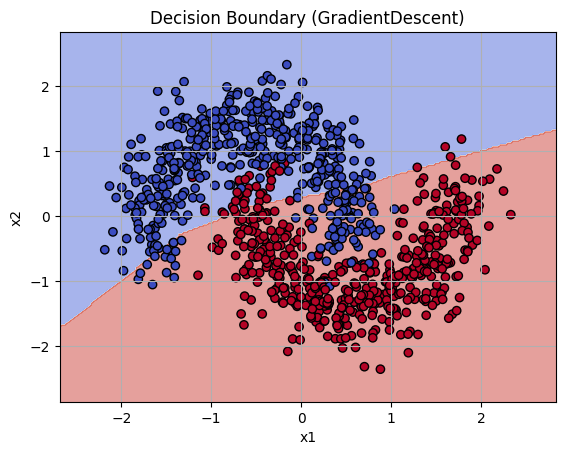

In [49]:
sys.path.append("..") 
from data.plot_decision_boundry import plot_decision_boundary 

plot_decision_boundary(model, X, y, title="Decision Boundary (GradientDescent)")

The model trained with the custom GradientDescent optimizer learned a basic separation between the two moon-shaped classes, capturing the general orientation of the boundary. However, the decision boundary appears mostly linear, leading to noticeable misclassifications in the overlapping central region. This suggests some underfitting, likely due to the model’s simplicity or the limitations of fixed learning rate gradient descent. Overall, it performed reasonably well but did not fully capture the curved structure of the data.

## Pros and Cons of Gradient Descent

### Pros
- **Simple to understand and implement**: This algorithm is straightforward and intuitive, making it ideal for learning and implementing fundamental machine learning optimization methods.
- **Works well for convex problems**: For convex loss functions, it will always converge to the global minimum.
- **Deterministic behavior**: The behavior is predictable and easy to debug.

### Cons
- **Sensitive to learning rate**: If the learning rate is too small, convergence is slow; if it's too large, the algorithm may diverge or oscillate.
- **Struggles with non-convex surfaces**: It can get stuck in local minima or saddle points for loss functions that are not convex.
- **Slow convergence**: Compared to advanced methods, regular gradient descent often requires more iterations to reach a satisfactory solution.

## Conclusion

In this notebook, I implemented gradient descent from scratch and demonstrated how it iteratively minimizes a loss function by following the opposite of the gradient direction. Using both simple mathematical functions and a neural network trained on a moon-shaped dataset with the custom implementation, I visualized how gradient descent updates parameters over time. While the optimizer successfully reduced loss and learned meaningful decision boundaries, its fixed learning rate and lack of adaptive behavior limited its performance on more complex data. This illustrates both the power and the limitations of regular gradient descent, laying a foundation for comparing it to more advanced methods.